In [340]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib as mpl
import tarfile
import numpy as np
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import cv2

In [341]:
# Path to dataset
dataroot = '/Users/mingukim/Desktop/TSKinFace_Data/TSKinFace_cropped/'
# Number of data loading workers
workers = 2
# Input batch size
batchSize = 64
# Input square image dimension to network (Height/width)
imageSize = 64
# Size of latent z vector
nz = 100
# Number of generator filters
ngf = 32
# Number of discriminator filters
ndf = 32
# Number of training epochs
niter = 300
# Learning rate (generator)
lr_g = 0.0002
# Learning rate (discriminator)
lr_d = 0.0002
# Beta1 for Adam
beta1 = 0.5
# Enable CUDA
use_gpu = False
# Number of GPUS to use
ngpu = 1
# Path to netG (to continue training for generator)
#pre_netG = 'pre_weights/netG_epoch_187.pth'
netG = 'weights/netG_epoch_303.pth'
# Path to netD (to continue training for discriminator)
#pre_netD = 'pre_weights/netD_epoch_187.pth'
netD = 'weights/netD_epoch_150.pth'
netdenoise = ''
# Output folder
outf = 'Generated'
# Weight folder
wfile = 'weights'
# Manual seed
manualSeed = None
# Number of channels
nc = 3
# Generate train data
need_data = False
ngpu = int(ngpu)
nz = int(nz)
ngf = int(ngf)
ndf = int(ndf)

In [298]:
# data_path = os.path.dirname('/Users/mingukim/Documents/cs281_fp/childGAN/children_photos')
# img_list = []
# for path, _, fnames in os.walk(data_path):
#     for fname in fnames:
#         if not fname.endswith('.png'):
#             continue
#         img = os.path.join(path, fname)
#         img_arr = cv2.imread(img)
#         img_arr = transform(img_arr)
#         img_list.append([img_arr])
# img_list = np.array(img_list)
# np.save('pre_data.npy', img_list)

In [299]:
def transform(data):
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = cv2.resize(data, (imageSize, imageSize)) 
    data = np.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = np.tile(data, (3, 1, 1))
    return data

if need_data:
    data_path = os.path.dirname('TSKinFace_cropped/All/')
    i = 0
    img_list = []
    for path, _, fnames in os.walk(data_path):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = cv2.imread(img)
            img_arr = transform(img_arr)
            if i % 3 == 0:
                img_list.append([img_arr])
            else:
                img_list[-1].append(img_arr)
            i += 1
    img_list2 = []
    data_path = os.path.dirname('TSKinFace_cropped/FMSD/')
    i = 0
    for path, _, fnames in os.walk(data_path):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = cv2.imread(img)
            img_arr = transform(img_arr)
            if i % 4 == 0:
                img_list2.append([img_arr])
            else:
                img_list2[-1].append(img_arr)
            i += 1
    img_list2 = np.array(img_list2)
    img_list = np.array(img_list)
    temp = np.zeros((228, 3, 3, 64, 64))
    temp[:, 0] = img_list2[:, 3]
    temp[:, 1] = img_list2[:, 1]
    temp[:, 2] = img_list2[:, 2]
    final = np.vstack((img_list, img_list2[:, :3], temp))
    np.save('data.npy', final)
    
def visualize(img_arr):
    im = ((img_arr.transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [ ]:
np.save()

In [301]:
# custom weights initialization called on netG and netD (inspired by https://github.com/pytorch/examples/blob/master/dcgan/main.py)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class _PreGenerator(nn.Module):
    def __init__(self, ngpu):
        super(_PreGenerator, self).__init__()
        self.ngpu = ngpu
        self.z_conv = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, int(ngf * 2) , 4, 1, 0, bias=False),
            nn.BatchNorm2d(int(ngf*2)),
            nn.ELU(True),
            # state size. (ngf*2) x 4 x 4
            nn.ConvTranspose2d(int(ngf * 2), int(ngf*2), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(ngf * 2)),
            nn.ELU(True), 
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(int(ngf*2) , ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ELU(True),
           # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ELU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh())
            # state size. (nc) x 64 x 64

    def forward(self, z):
        output = self.z_conv(z)
        return output
    

class _Generator(nn.Module):
    def __init__(self, ngpu):
        super(_Generator, self).__init__()
        self.ngpu = ngpu
        self.first_conv = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ELU(True),
            nn.Dropout(0.5),
            # state is (ngf) x 32 x 32
            nn.Conv2d(ngf, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ELU(True))
            # state is (ngf * 2) x 16 x 16
            
        self.z_conv = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, int(ngf * 2) , 4, (1, 1, 1, 1), 0, bias=False),
            nn.BatchNorm2d(int(ngf*2)),
            nn.ELU(True),
            # state size. (ngf*2) x 4 x 4
            nn.ConvTranspose2d(int(ngf * 2), int(ngf*2), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(ngf * 2)),
            nn.ELU(True), 
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(int(ngf*2) , ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ELU(True))
            # state size. (ngf*2) x 16 x 16
        
        
        self.final_conv = nn.Sequential(
            # state size. (ngf * 5) x 16 x 16
            nn.ConvTranspose2d(ngf * 5, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ELU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh())
            # state size. (nc) x 64 x 64

    def forward(self, parent_1, parent_2, z):
        output = self.final_conv(torch.cat((self.first_conv(parent_1), self.first_conv(parent_2), self.z_conv(z)), 1))
        return output

    
class _PreDiscriminator(nn.Module):
    def __init__(self, ngpu):
        super(_PreDiscriminator, self).__init__()
        self.ngpu = ngpu
        self.conv = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf * 2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, test_pic):
        output = self.conv(test_pic)
        return output.view(-1, 1).squeeze(1)    
    
class _Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(_Discriminator, self).__init__()
        self.ngpu = ngpu
        self.parent_conv = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True))
            # state size. (ndf * 2) x 16 x 16
        
        
        self.final_conv = nn.Sequential(
            # state size. (ndf*6) x 16 x 16
            nn.Conv2d(ndf * 6, ndf * 6, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 6),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*6) x 8 x 8
            nn.Conv2d(ndf * 6, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, parent_1, parent_2, test_pic):
        output = self.final_conv(torch.cat((self.parent_conv(parent_1), self.parent_conv(parent_2), self.parent_conv(test_pic)), 1))
        return output.view(-1, 1).squeeze(1)


generator = _Generator(ngpu)
generator.apply(weights_init)
#pregen = _PreGenerator(ngpu)
if netG != '':
    generator.load_state_dict(torch.load(netG))
# if pre_netG != '':
#     pregen.load_state_dict(torch.load(pre_netG))

# pre_trained_weights = []
# layers = [0, 1, 3, 4]
# for i in layers:
#     generator.z_conv[i].weight = pregen.z_conv[i].weight

    

discriminator = _Discriminator(ngpu)
discriminator.apply(weights_init)
if netD != '':
    discriminator.load_state_dict(torch.load(netD))

criterion = nn.BCELoss()  
denoise_loss = nn.MSELoss()
input1 = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
input2 = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
input3 = torch.FloatTensor(batchSize, 3, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0
one = torch.FloatTensor([1])
mone = one * -1

if use_gpu:
    discriminator.cuda()
    generator.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# setup optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr_g, betas=(beta1, 0.999))

In [233]:
data = np.load('data.npy')
np.random.shuffle(data)
train_data = np.array(np.array_split(data[:900], np.ceil(900 / batchSize)))
test_data = np.array(np.array_split(data[900:], np.ceil((data.shape[0] - 900)/ batchSize)))
ep_start = 358
d_values = []
g_values = []
for epoch in range(ep_start, ep_start + niter):
    for i, image in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ######################
        # train with real
        for p in discriminator.parameters(): 
            p.requires_grad = True 
        child_counter = 0
        for child in generator.children():
            if child_counter == 1:
                sec_count = 0
                for sec_child in child.children():
                    if sec_count in layers:
                        for param in sec_child.parameters():
                            param.requires_grad = False
                    sec_count += 1
            child_counter += 1
        discriminator.zero_grad()
        target, parent_1, parent_2 = image[:, 0], image[:, 1], image[:, 2]
        batch_size = target.shape[0]
        label.resize_(batch_size).fill_(real_label)
        inputv1 = Variable(torch.Tensor(parent_1))
        inputv2 = Variable(torch.Tensor(parent_2))
        inputv3 = Variable(torch.Tensor(target))
        labelv = Variable(label)
        
        real_Dis = discriminator(inputv1, inputv2, inputv3)
        errD_real = criterion(real_Dis, labelv)
        errD_real.backward()
        D_x = real_Dis.data.mean()
        #d_values.append(D_x)
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = generator(inputv1, inputv2, noisev) 
        labelv = Variable(label.fill_(fake_label))
        output = discriminator(inputv1, inputv2, fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        #g_values.append(D_G_z1)
        errD = errD_real + errD_fake
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        for p in discriminator.parameters(): 
            p.requires_grad = False
        generator.zero_grad()

        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = discriminator(inputv1, inputv2, fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        if i % 5 == 1:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, ep_start + niter, i, train_data.shape[0],
                     errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
            
            for i, image in enumerate(test_data):
                target, parent_1, parent_2 = image[:, 0], image[:, 1], image[:, 2]
                batch_size = target.shape[0]
                label.resize_(batch_size).fill_(real_label)
                inputv1 = Variable(torch.Tensor(parent_1))
                inputv2 = Variable(torch.Tensor(parent_2))
                inputv3 = Variable(torch.Tensor(target))
                labelv = Variable(label)
                real_Dis = discriminator(inputv1, inputv2, inputv3)
                errD_real = criterion(real_Dis, labelv)
                D_x = real_Dis.data.mean()
                d_values.append(D_x)
                noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
                noisev = Variable(noise)
                fake = generator(inputv1, inputv2, noisev) 
                labelv = Variable(label.fill_(fake_label))
                output = discriminator(inputv1, inputv2, fake.detach())
                errD_fake = criterion(output, labelv)
                D_G_z1 = output.data.mean()
                g_values.append(D_G_z1)
                errD = errD_real + errD_fake
                labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
                output = discriminator(inputv1, inputv2, fake)
                errG = criterion(output, labelv)
                D_G_z2 = output.data.mean()
            print('Test Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (
                     errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
            cv2.imwrite('%s/real_child.png' % outf, ((target[0].transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
            cv2.imwrite('%s/real_parent1.png' % outf, ((parent_1[0].transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
            cv2.imwrite('%s/real_parent2.png' % outf, ((parent_2[0].transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
            fake = generator(inputv1, inputv2, noisev)
            cv2.imwrite('%s/fake_samples_epoch_%03d.png' % (outf, epoch), ((fake.data.numpy()[0].transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))

    # do checkpointing
    torch.save(generator.state_dict(), '%s/netG_epoch_%d.pth' % (wfile, epoch))
    torch.save(discriminator.state_dict(), '%s/netD_epoch_%d.pth' % (wfile, epoch))

[358/658][1/15] Loss_D: 0.7057 Loss_G: 6.1644 D(x): 0.9954 D(G(z)): 0.3263 / 0.0082
Test Loss_D: 0.2231 Loss_G: 4.3865 D(x): 0.8932 D(G(z)): 0.0643 / 0.0643
[358/658][6/15] Loss_D: 0.2655 Loss_G: 6.5274 D(x): 0.9111 D(G(z)): 0.0570 / 0.0079
Test Loss_D: 0.1912 Loss_G: 5.5392 D(x): 0.8913 D(G(z)): 0.0314 / 0.0314
[358/658][11/15] Loss_D: 0.2899 Loss_G: 4.9077 D(x): 0.8886 D(G(z)): 0.0215 / 0.0432
Test Loss_D: 0.1578 Loss_G: 3.7170 D(x): 0.9786 D(G(z)): 0.1055 / 0.1055
[359/658][1/15] Loss_D: 0.1077 Loss_G: 5.8585 D(x): 0.9456 D(G(z)): 0.0176 / 0.0110
Test Loss_D: 0.3196 Loss_G: 3.6281 D(x): 0.9683 D(G(z)): 0.1664 / 0.1664
[359/658][6/15] Loss_D: 0.1203 Loss_G: 6.4220 D(x): 0.9723 D(G(z)): 0.0690 / 0.0061
Test Loss_D: 0.1772 Loss_G: 5.4842 D(x): 0.9011 D(G(z)): 0.0275 / 0.0275
[359/658][11/15] Loss_D: 0.1829 Loss_G: 5.5260 D(x): 0.9212 D(G(z)): 0.0395 / 0.0173
Test Loss_D: 0.2387 Loss_G: 5.1868 D(x): 0.9314 D(G(z)): 0.0653 / 0.0653
[360/658][1/15] Loss_D: 0.0465 Loss_G: 6.2985 D(x): 0.97

KeyboardInterrupt: 

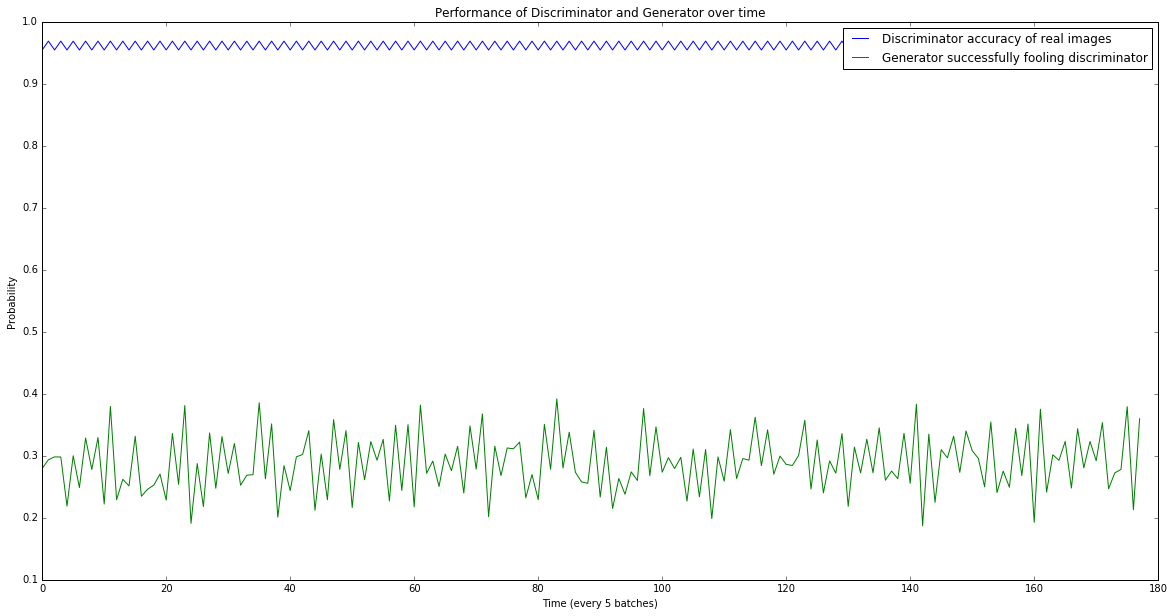

In [225]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(d_values)), d_values, label='Discriminator accuracy of real images')
plt.plot(range(len(g_values)), g_values, label='Generator successfully fooling discriminator')
plt.xlabel('Time (every 5 batches)')
plt.ylabel('Probability')
plt.legend()
plt.title('Performance of Discriminator and Generator over time')
plt.show()

In [339]:
np.save('parent4_1.npy', img_arr1)
np.save('parent4_2.npy', img_arr2)

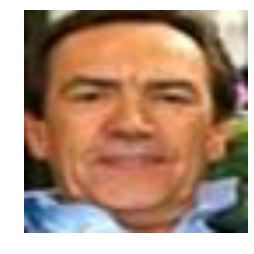

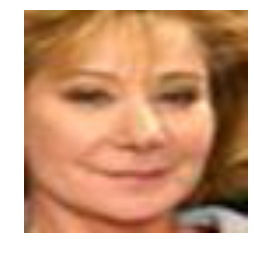

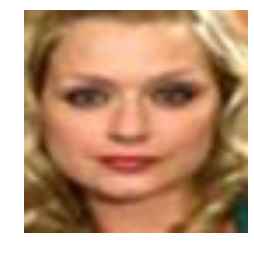

In [350]:
ID = 161
path = dataroot + 'FMSD/'
img1 = os.path.join(path, 'FMSD-' + str(ID) + '-F.jpg')
img_arr1 = cv2.imread(img1)
img_arr1 = transform(img_arr1)
img2 = os.path.join(path, 'FMSD-' + str(ID) + '-M.jpg')
img_arr2 = cv2.imread(img2)
img_arr2 = transform(img_arr2)
img3 = os.path.join(path, 'FMSD-' + str(ID) + '-D.jpg')
img_arr3 = cv2.imread(img3)
img_arr3 = transform(img_arr3)
visualize(img_arr1)
plt.show()
visualize(img_arr2)
plt.show()
visualize(img_arr3)
plt.show()
# for i in range(10):
#     noise.resize_(1, nz, 1, 1).normal_(0, 1)
#     noisev = Variable(noise)
#     im1 = Variable(torch.Tensor(img_arr1.reshape(1, 3, 64, 64)))
#     im2 =  Variable(torch.Tensor(img_arr2.reshape(1, 3, 64, 64)))
#     fake = generator(im1, im2, noisev)
#     visualize(fake.data.numpy()[0])
#     plt.show()

In [347]:
alex_img = np.load('supervised_z0.npy')

In [348]:
g_values = []
d_values = []
image = alex_img
parent_1, parent_2, target = image[:, 0], image[:, 1], image[:, 2]
batch_size = target.shape[0]
label.resize_(batch_size).fill_(real_label)
inputv1 = Variable(torch.Tensor(parent_1))
inputv2 = Variable(torch.Tensor(parent_2))
inputv3 = Variable(torch.Tensor(target))
labelv = Variable(label)
real_Dis = discriminator(inputv1, inputv2, inputv3)
errD_real = criterion(real_Dis, labelv)
D_x = real_Dis.data.mean()
d_values.append(D_x)
noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)
fake = generator(inputv1, inputv2, noisev) 
labelv = Variable(label.fill_(fake_label))
output = discriminator(inputv1, inputv2, fake.detach())
errD_fake = criterion(output, labelv)
D_G_z1 = output.data.mean()
g_values.append(D_G_z1)
errD = errD_real + errD_fake
labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
output = discriminator(inputv1, inputv2, fake)
errG = criterion(output, labelv)
D_G_z2 = output.data.mean()

In [349]:
np.mean(d_values)

0.0011333700798169997

In [34]:
data = np.load('pre_data.npy')
np.random.shuffle(data)
train_data = np.array(np.array_split(data, np.ceil(data.shape[0] / batchSize)))

In [65]:
data = np.load('pre_data.npy')
np.random.shuffle(data)
train_data = np.array(np.array_split(data, np.ceil(data.shape[0] / batchSize)))
ep_start = 126
for epoch in range(ep_start, ep_start + niter):
    for i, image in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ######################
        # train with real
        for p in discriminator.parameters(): 
            p.requires_grad = True 
        discriminator.zero_grad()
        target = image[:, 0]
        batch_size = target.shape[0]
        label.resize_(batch_size).fill_(real_label)
        inputv3 = Variable(torch.Tensor(target))
        labelv = Variable(label) 
        real_Dis = discriminator(inputv3)
        errD_real = criterion(real_Dis, labelv)
        errD_real.backward()
        D_x = real_Dis.data.mean()
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = generator(noisev) 
        labelv = Variable(label.fill_(fake_label))
        output = discriminator(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()


        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        for p in discriminator.parameters(): 
            p.requires_grad = False
        generator.zero_grad()

        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = discriminator(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        if i % 10 == 1:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, ep_start + niter, i, train_data.shape[0],
                     errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
            fake = generator(noisev)
            cv2.imwrite('%s/fake_samples_epoch_%03d.png' % (outf, epoch), ((fake.data.numpy()[0].transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))

    # do checkpointing
    torch.save(generator.state_dict(), '%s/netG_epoch_%d.pth' % (wfile, epoch))
    torch.save(discriminator.state_dict(), '%s/netD_epoch_%d.pth' % (wfile, epoch))

[126/426][1/93] Loss_D: 0.8573 Loss_G: 2.0199 D(x): 0.6159 D(G(z)): 0.0758 / 0.2676
[126/426][11/93] Loss_D: 0.3023 Loss_G: 4.0979 D(x): 0.8774 D(G(z)): 0.1074 / 0.0490
[126/426][21/93] Loss_D: 0.2357 Loss_G: 4.2898 D(x): 0.8678 D(G(z)): 0.0622 / 0.0391
[126/426][31/93] Loss_D: 0.2490 Loss_G: 5.8211 D(x): 0.9377 D(G(z)): 0.1104 / 0.0076
[126/426][41/93] Loss_D: 0.1125 Loss_G: 4.5834 D(x): 0.9272 D(G(z)): 0.0289 / 0.0235
[126/426][51/93] Loss_D: 0.1670 Loss_G: 5.3640 D(x): 0.9480 D(G(z)): 0.0896 / 0.0115
[126/426][61/93] Loss_D: 0.1562 Loss_G: 4.6202 D(x): 0.9451 D(G(z)): 0.0703 / 0.0288
[126/426][71/93] Loss_D: 0.1007 Loss_G: 4.8425 D(x): 0.9672 D(G(z)): 0.0577 / 0.0178
[126/426][81/93] Loss_D: 0.1541 Loss_G: 5.4586 D(x): 0.9829 D(G(z)): 0.1132 / 0.0086
[126/426][91/93] Loss_D: 0.2065 Loss_G: 4.2422 D(x): 0.8544 D(G(z)): 0.0147 / 0.0654
[127/426][1/93] Loss_D: 0.1311 Loss_G: 5.1181 D(x): 0.9156 D(G(z)): 0.0330 / 0.0158
[127/426][11/93] Loss_D: 0.0966 Loss_G: 5.2313 D(x): 0.9715 D(G(z))

[135/426][71/93] Loss_D: 0.0848 Loss_G: 4.1423 D(x): 0.9332 D(G(z)): 0.0097 / 0.0481
[135/426][81/93] Loss_D: 0.1574 Loss_G: 4.3379 D(x): 0.9178 D(G(z)): 0.0372 / 0.0457
[135/426][91/93] Loss_D: 0.0723 Loss_G: 4.5604 D(x): 0.9488 D(G(z)): 0.0074 / 0.0427
[136/426][1/93] Loss_D: 0.0706 Loss_G: 4.7625 D(x): 0.9443 D(G(z)): 0.0092 / 0.0292
[136/426][11/93] Loss_D: 0.0697 Loss_G: 5.4805 D(x): 0.9670 D(G(z)): 0.0326 / 0.0107
[136/426][21/93] Loss_D: 0.0781 Loss_G: 5.5525 D(x): 0.9497 D(G(z)): 0.0143 / 0.0152
[136/426][31/93] Loss_D: 5.8944 Loss_G: 0.8164 D(x): 0.0135 D(G(z)): 0.0001 / 0.6627
[136/426][41/93] Loss_D: 0.3373 Loss_G: 7.5948 D(x): 0.9803 D(G(z)): 0.2101 / 0.0020
[136/426][51/93] Loss_D: 0.2010 Loss_G: 5.1108 D(x): 0.9336 D(G(z)): 0.0818 / 0.0167
[136/426][61/93] Loss_D: 0.1047 Loss_G: 5.0154 D(x): 0.9473 D(G(z)): 0.0369 / 0.0205
[136/426][71/93] Loss_D: 0.2305 Loss_G: 3.8510 D(x): 0.8954 D(G(z)): 0.0436 / 0.0544
[136/426][81/93] Loss_D: 0.1792 Loss_G: 5.4782 D(x): 0.9612 D(G(z)

[145/426][41/93] Loss_D: 0.1039 Loss_G: 5.9968 D(x): 0.9626 D(G(z)): 0.0477 / 0.0102
[145/426][51/93] Loss_D: 0.0624 Loss_G: 5.1663 D(x): 0.9539 D(G(z)): 0.0126 / 0.0187
[145/426][61/93] Loss_D: 0.0656 Loss_G: 5.4141 D(x): 0.9638 D(G(z)): 0.0268 / 0.0182
[145/426][71/93] Loss_D: 0.0487 Loss_G: 5.4069 D(x): 0.9714 D(G(z)): 0.0184 / 0.0125
[145/426][81/93] Loss_D: 0.0899 Loss_G: 4.9743 D(x): 0.9569 D(G(z)): 0.0380 / 0.0210
[145/426][91/93] Loss_D: 0.0512 Loss_G: 6.6143 D(x): 0.9751 D(G(z)): 0.0212 / 0.0054
[146/426][1/93] Loss_D: 0.0673 Loss_G: 5.8124 D(x): 0.9825 D(G(z)): 0.0418 / 0.0084
[146/426][11/93] Loss_D: 0.0414 Loss_G: 5.3965 D(x): 0.9830 D(G(z)): 0.0221 / 0.0129
[146/426][21/93] Loss_D: 0.0928 Loss_G: 6.3074 D(x): 0.9806 D(G(z)): 0.0610 / 0.0051
[146/426][31/93] Loss_D: 0.1085 Loss_G: 5.4606 D(x): 0.9415 D(G(z)): 0.0318 / 0.0142
[146/426][41/93] Loss_D: 0.0402 Loss_G: 5.9025 D(x): 0.9852 D(G(z)): 0.0231 / 0.0075
[146/426][51/93] Loss_D: 0.1102 Loss_G: 6.3536 D(x): 0.9913 D(G(z)

[155/426][11/93] Loss_D: 0.1704 Loss_G: 5.0933 D(x): 0.9235 D(G(z)): 0.0563 / 0.0257
[155/426][21/93] Loss_D: 0.0992 Loss_G: 4.5980 D(x): 0.9575 D(G(z)): 0.0461 / 0.0254
[155/426][31/93] Loss_D: 0.1393 Loss_G: 4.4989 D(x): 0.9261 D(G(z)): 0.0458 / 0.0297
[155/426][41/93] Loss_D: 0.0705 Loss_G: 5.3988 D(x): 0.9725 D(G(z)): 0.0367 / 0.0132
[155/426][51/93] Loss_D: 0.1102 Loss_G: 5.5970 D(x): 0.9535 D(G(z)): 0.0491 / 0.0114
[155/426][61/93] Loss_D: 0.1135 Loss_G: 4.8653 D(x): 0.9315 D(G(z)): 0.0265 / 0.0257
[155/426][71/93] Loss_D: 0.1307 Loss_G: 6.1097 D(x): 0.9746 D(G(z)): 0.0776 / 0.0068
[155/426][81/93] Loss_D: 0.0625 Loss_G: 5.3524 D(x): 0.9690 D(G(z)): 0.0284 / 0.0142
[155/426][91/93] Loss_D: 0.1479 Loss_G: 6.1454 D(x): 0.8841 D(G(z)): 0.0027 / 0.0079
[156/426][1/93] Loss_D: 0.1590 Loss_G: 7.0639 D(x): 0.9889 D(G(z)): 0.1088 / 0.0022
[156/426][11/93] Loss_D: 0.0615 Loss_G: 4.4947 D(x): 0.9577 D(G(z)): 0.0158 / 0.0257
[156/426][21/93] Loss_D: 0.0748 Loss_G: 5.5100 D(x): 0.9865 D(G(z)

[164/426][81/93] Loss_D: 0.1244 Loss_G: 4.0031 D(x): 0.9071 D(G(z)): 0.0153 / 0.0537
[164/426][91/93] Loss_D: 0.0927 Loss_G: 5.8843 D(x): 0.9564 D(G(z)): 0.0303 / 0.0084
[165/426][1/93] Loss_D: 0.0811 Loss_G: 5.5448 D(x): 0.9797 D(G(z)): 0.0525 / 0.0112
[165/426][11/93] Loss_D: 0.0857 Loss_G: 5.8626 D(x): 0.9634 D(G(z)): 0.0389 / 0.0094
[165/426][21/93] Loss_D: 0.0696 Loss_G: 5.2162 D(x): 0.9605 D(G(z)): 0.0252 / 0.0206
[165/426][31/93] Loss_D: 0.0661 Loss_G: 5.3479 D(x): 0.9593 D(G(z)): 0.0199 / 0.0180
[165/426][41/93] Loss_D: 0.0405 Loss_G: 6.6216 D(x): 0.9743 D(G(z)): 0.0132 / 0.0055
[165/426][51/93] Loss_D: 0.0760 Loss_G: 5.7730 D(x): 0.9831 D(G(z)): 0.0498 / 0.0076
[165/426][61/93] Loss_D: 0.1266 Loss_G: 7.2976 D(x): 0.9863 D(G(z)): 0.0936 / 0.0018
[165/426][71/93] Loss_D: 0.1071 Loss_G: 5.1028 D(x): 0.9650 D(G(z)): 0.0402 / 0.0188
[165/426][81/93] Loss_D: 0.0626 Loss_G: 5.3827 D(x): 0.9666 D(G(z)): 0.0246 / 0.0182
[165/426][91/93] Loss_D: 0.2615 Loss_G: 4.2408 D(x): 0.8234 D(G(z)

[174/426][51/93] Loss_D: 0.0878 Loss_G: 5.2651 D(x): 0.9662 D(G(z)): 0.0400 / 0.0127
[174/426][61/93] Loss_D: 0.0928 Loss_G: 4.2328 D(x): 0.9536 D(G(z)): 0.0389 / 0.0371
[174/426][71/93] Loss_D: 0.0798 Loss_G: 5.0361 D(x): 0.9685 D(G(z)): 0.0422 / 0.0161
[174/426][81/93] Loss_D: 0.0607 Loss_G: 5.3418 D(x): 0.9581 D(G(z)): 0.0087 / 0.0144
[174/426][91/93] Loss_D: 0.1520 Loss_G: 5.9554 D(x): 0.8813 D(G(z)): 0.0023 / 0.0084
[175/426][1/93] Loss_D: 0.1322 Loss_G: 6.3932 D(x): 0.9798 D(G(z)): 0.0648 / 0.0056
[175/426][11/93] Loss_D: 0.0534 Loss_G: 4.8723 D(x): 0.9812 D(G(z)): 0.0313 / 0.0213
[175/426][21/93] Loss_D: 0.1667 Loss_G: 6.6643 D(x): 0.9723 D(G(z)): 0.0970 / 0.0056
[175/426][31/93] Loss_D: 0.0673 Loss_G: 5.4611 D(x): 0.9651 D(G(z)): 0.0285 / 0.0122
[175/426][41/93] Loss_D: 0.0425 Loss_G: 6.8451 D(x): 0.9844 D(G(z)): 0.0232 / 0.0055
[175/426][51/93] Loss_D: 0.0804 Loss_G: 5.7146 D(x): 0.9761 D(G(z)): 0.0354 / 0.0101
[175/426][61/93] Loss_D: 0.0718 Loss_G: 4.9063 D(x): 0.9541 D(G(z)

[184/426][21/93] Loss_D: 0.0657 Loss_G: 5.5728 D(x): 0.9639 D(G(z)): 0.0235 / 0.0136
[184/426][31/93] Loss_D: 0.0787 Loss_G: 5.6454 D(x): 0.9692 D(G(z)): 0.0345 / 0.0115
[184/426][41/93] Loss_D: 0.0489 Loss_G: 6.6149 D(x): 0.9901 D(G(z)): 0.0333 / 0.0044
[184/426][51/93] Loss_D: 0.0299 Loss_G: 5.9705 D(x): 0.9796 D(G(z)): 0.0088 / 0.0079
[184/426][61/93] Loss_D: 0.0614 Loss_G: 5.1622 D(x): 0.9482 D(G(z)): 0.0037 / 0.0182
[184/426][71/93] Loss_D: 0.0795 Loss_G: 6.3043 D(x): 0.9538 D(G(z)): 0.0245 / 0.0088
[184/426][81/93] Loss_D: 0.0620 Loss_G: 6.5557 D(x): 0.9818 D(G(z)): 0.0355 / 0.0068
[184/426][91/93] Loss_D: 0.0858 Loss_G: 5.7415 D(x): 0.9363 D(G(z)): 0.0103 / 0.0174
[185/426][1/93] Loss_D: 0.1159 Loss_G: 7.4434 D(x): 0.9527 D(G(z)): 0.0492 / 0.0036
[185/426][11/93] Loss_D: 1.1365 Loss_G: 1.6005 D(x): 0.6694 D(G(z)): 0.2648 / 0.4028
[185/426][21/93] Loss_D: 0.7792 Loss_G: 7.2808 D(x): 0.9695 D(G(z)): 0.3387 / 0.0025
[185/426][31/93] Loss_D: 0.1940 Loss_G: 4.7322 D(x): 0.9227 D(G(z)

KeyboardInterrupt: 